Dataset Used: <a href="https://www.kaggle.com/c/fake-news/data" target="_blank">Here</a>

Labels for Data:

- 0 = Higher probability for Fake News
- 1 = Higher probability for Factual News

In [1]:
# Import required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Tensorflow-Keras Library
import tensorflow.keras
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

# Import Custom Functions
from Functions import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\russe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Import Dataset
data = pd.read_csv('Project_Dataset/train.csv')
data_test = pd.read_csv('Project_Dataset/test.csv')
# data.head()
data_test.head()

,title,author,source
0,Bill Maher on Atlanta-area massage parlor shoo...,Fox News,Fox News
1,US and China trade angry words at high-level A...,BBC News,BBC News
2,Sarm Heslop was last seen on this 47-foot cata...,Fox News,Fox News
3,Covid: France and Poland increase lockdown mea...,BBC News,BBC News
4,John Solomon: Top Democrat fundraiser has ties...,Fox News,Fox News


In [4]:
data_test.loc[data_test['author'] == "Fox News"]

,title,author,source
0,Bill Maher on Atlanta-area massage parlor shoo...,Fox News,Fox News
2,Sarm Heslop was last seen on this 47-foot cata...,Fox News,Fox News
4,John Solomon: Top Democrat fundraiser has ties...,Fox News,Fox News
5,Federal judge warns 'dangerous' media has 'ver...,Fox News,Fox News
8,Tucker: Beijing using Black Lives Matter as a ...,Fox News,Fox News
11,Monopoly getting 'long overdue' socially consc...,Fox News,Fox News
14,Texas Gov. Abbott: Border crisis is now 'a hum...,Fox News,Fox News
15,"Maria Bartiromo: China is using 'progressive, ...",Fox News,Fox News
19,WH axes staffers over past pot use even though...,Fox News,Fox News
42,"Biden stumbles multiple times, falls as he sca...",Fox News,Fox News


## Preprocessing and Cleaning

In [109]:
# Fill Any Null Values
data = data.fillna('')
data_test = data_test.fillna('')

# Combine columns for analysis
data['compiled'] = data['title'] + ' ' + data['author']
data_test['compiled'] = data_test['title'] + ' ' + data_test['author']

# Get Targets
X = data.drop('label', axis=1)
X_test = data_test.copy()
y = data['label']

# Preprocess Data & convert to Matrix arrays
X_final_train = np.array(pre_process(X,max_vocab))
X_final_test = np.array(pre_process(X_test,max_vocab))
y_final_train = np.array(y)
print(X_final_train.shape,X_final_test.shape, y_final_train.shape)

(20800, 25)
(61, 25)
(20800, 25) (61, 25) (20800,)


## Model Creation - LSTM with Embedding Layer

In [8]:
# Establish Custom Layer Parameters
lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=2e-4, decay_steps=1000, decay_rate=0.07)

opt = tensorflow.keras.optimizers.Adam(learning_rate=lr_schedule)

# Initialise layers
model = Sequential()
model.add(Embedding(max_vocab,40,input_length=25))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 25, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [9]:
# Fit Model on train Data
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(X_final_train,y_final_train,validation_split=0.20,epochs=20,batch_size=64, callbacks=[es])

Epoch 1/20
260/260 [==============================] - 7s 22ms/step - loss: 0.5893 - accuracy: 0.7405 - val_loss: 0.2550 - val_accuracy: 0.8945
Epoch 2/20
260/260 [==============================] - 5s 20ms/step - loss: 0.2130 - accuracy: 0.9137 - val_loss: 0.1361 - val_accuracy: 0.9502
Epoch 3/20
260/260 [==============================] - 5s 21ms/step - loss: 0.1366 - accuracy: 0.9538 - val_loss: 0.1109 - val_accuracy: 0.9599
Epoch 4/20
260/260 [==============================] - 5s 21ms/step - loss: 0.1100 - accuracy: 0.9602 - val_loss: 0.1020 - val_accuracy: 0.9632
Epoch 5/20
260/260 [==============================] - 5s 21ms/step - loss: 0.1067 - accuracy: 0.9623 - val_loss: 0.0984 - val_accuracy: 0.9630
Epoch 6/20
260/260 [==============================] - 5s 21ms/step - loss: 0.1005 - accuracy: 0.9650 - val_loss: 0.0976 - val_accuracy: 0.9637
Epoch 7/20
260/260 [==============================] - 5s 21ms/step - loss: 0.0994 - accuracy: 0.9658 - val_loss: 0.0959 - val_accuracy: 0.9644

In [45]:
# Save model
#model.save('LSTM_Model_Stable.h5')

# Loads saved Model
# loaded_model = load_model('Models/LSTM_Model_Stable.h5')
# print("Model Loaded Successfully")

## Predict On Test Data and Store results as CSV

In [110]:
# Make Predictions on real-time Data
y_pred = (history.model.predict(X_final_test)>0.5).astype('int32')

# Tabulate Results
results_table = pd.DataFrame()
results_table[['title','source']] = data_test[['title','source']]
results_table['label'] = y_pred
results_table = results_table.sort_values(by=['source'])
# Save Results as CSV File
results_table.to_csv(path_or_buf='Project_Dataset/results.csv', index=False)

## Visualize Model Training

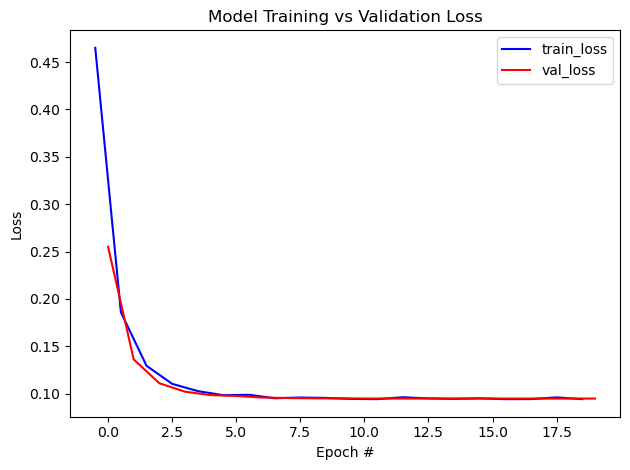

In [91]:
# Visualize Model Training and Model Convergence
%matplotlib inline

epochs = np.arange(0, len(history.history["loss"]))
plt.style.use("default")

plt.plot(epochs - 0.5, history.history["loss"], label="train_loss", color="Blue")
plt.plot(epochs, history.history["val_loss"], label="val_loss",color="Red")
plt.title("Model Training vs Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [107]:
import gc
collected = gc.collect()
print("Garbage collector: collected","%d objects." % collected) 

Garbage collector: collected 2088 objects.
